In [1]:
import unittest
import numpy as np
import os
import pycqed as pq
import time

import pycqed.analysis.analysis_toolbox as a_tools

import pycqed.instrument_drivers.virtual_instruments.virtual_AWG8 as v8
import pycqed.instrument_drivers.virtual_instruments.virtual_SignalHound as sh
import pycqed.instrument_drivers.virtual_instruments.virtual_MW_source as vmw
from pycqed.instrument_drivers.meta_instrument.LutMans import mw_lutman as mwl
from pycqed.measurement.waveform_control_CC import waveform as wf
import pycqed.instrument_drivers.meta_instrument.qubit_objects.CCL_Transmon as ct
from pycqed.measurement import measurement_control
from qcodes import station

from pycqed.instrument_drivers.physical_instruments.ZurichInstruments.dummy_UHFQC import dummy_UHFQC

from pycqed.instrument_drivers.physical_instruments.QuTech_Duplexer import Dummy_Duplexer


from pycqed.instrument_drivers.meta_instrument.qubit_objects.QuDev_transmon import QuDev_transmon
from pycqed.instrument_drivers.meta_instrument.qubit_objects.Tektronix_driven_transmon import Tektronix_driven_transmon
from pycqed.instrument_drivers.meta_instrument.qubit_objects.CC_transmon import CBox_v3_driven_transmon, QWG_driven_transmon
from pycqed.instrument_drivers.physical_instruments.QuTech_CCL import dummy_CCL
from pycqed.instrument_drivers.physical_instruments.QuTech_VSM_Module import Dummy_QuTechVSMModule
from pycqed.instrument_drivers.meta_instrument.LutMans.ro_lutman import UHFQC_RO_LutMan

Dummy_VSM_not_fixed = False

try:
    import openql
    openql_import_fail = False
except:
    openql_import_fail = True


station = station.Station()
q0 = ct.CCLight_Transmon('q0')
q1 = ct.CCLight_Transmon('q1')
q2 = ct.CCLight_Transmon('q2')

MW1 = vmw.VirtualMWsource('MW1')
MW2 = vmw.VirtualMWsource('MW2')
MW3 = vmw.VirtualMWsource('MW3')
SH = sh.virtual_SignalHound_USB_SA124B('SH')
UHFQC = dummy_UHFQC('UHFQC')

CCL = dummy_CCL('CCL')
# VSM = Dummy_Duplexer('VSM')
VSM = Dummy_QuTechVSMModule('VSM')

MC = measurement_control.MeasurementControl(
            'MC', live_plot_enabled=False, verbose=False)
MC.station = station
station.add_component(MC)

# Required to set it to the testing datadir
test_datadir = os.path.join(pq.__path__[0], 'tests', 'test_output')
MC.datadir(test_datadir)
a_tools.datadir = MC.datadir()

AWG = v8.VirtualAWG8('DummyAWG8')
AWG8_VSM_MW_LutMan = mwl.AWG8_VSM_MW_LutMan('MW_LutMan_VSM')
AWG8_VSM_MW_LutMan.AWG(AWG.name)
AWG8_VSM_MW_LutMan.channel_GI(1)
AWG8_VSM_MW_LutMan.channel_GQ(2)
AWG8_VSM_MW_LutMan.channel_DI(3)
AWG8_VSM_MW_LutMan.channel_DQ(4)
AWG8_VSM_MW_LutMan.mw_modulation(100e6)
AWG8_VSM_MW_LutMan.sampling_rate(2.4e9)

ro_lutman = UHFQC_RO_LutMan('RO_lutman', num_res=5)
ro_lutman.AWG(UHFQC.name)

# Assign instruments
for qi in [q0, q1, q2]:
    qi.instr_LutMan_MW(AWG8_VSM_MW_LutMan.name)
    qi.instr_LO_ro(MW1.name)
    qi.instr_LO_mw(MW2.name)
    qi.instr_spec_source(MW3.name)

    qi.instr_acquisition(UHFQC.name)
    qi.instr_VSM(VSM.name)
    qi.instr_CC(CCL.name)
    qi.instr_LutMan_RO(ro_lutman.name)
    qi.instr_MC(MC.name)

    qi.instr_SH(SH.name)

    config_fn = os.path.join(pq.__path__[0], 'tests', 'test_cfg_CCL.json')
    qi.cfg_openql_platform_fn(config_fn)

            # Setting some "random" initial parameters
    qi.ro_freq(5.43e9)
    qi.ro_freq_mod(200e6)

    qi.freq_qubit(4.56e9)
    qi.freq_max(4.62e9)

    qi.mw_freq_mod(-100e6)
    qi.mw_awg_ch(1)
    qi.cfg_qubit_nr(0)

    qi.mw_vsm_delay(15)

    qi.mw_mixer_offs_GI(.1)
    qi.mw_mixer_offs_GQ(.2)
    qi.mw_mixer_offs_DI(.3)
    qi.mw_mixer_offs_DQ(.4)

Data directory set to: /Users/Adriaan/Dropbox/PhD-Delft/Data


Could not import msvcrt (used for detecting keystrokes)
Connected to: <CCLight_Transmon: q0> in 0.01 s
Connected to: <CCLight_Transmon: q1> in 0.01 s
Connected to: <CCLight_Transmon: q2> in 0.01 s
Connected to: None MW1 (serial:None, firmware:None) in 0.00s
Connected to: None MW2 (serial:None, firmware:None) in 0.00s
Connected to: None MW3 (serial:None, firmware:None) in 0.00s
Initialized SignalHound in 0.00s
Initialized dummy UHFQC UHFQC in 0.02s
Connected to: None None (serial:None, firmware:None) in 0.00s
Connected to:  VSM (serial:Dummy, firmware:) in 0.04s


In [2]:
from importlib import reload
import autodepgraph.graph_v2 as g
reload(g)
from autodepgraph.graph_v2 import AutoDepGraph_DAG
import networkx as nx

In [3]:
reload(g.vis)

<module 'autodepgraph.visualization' from '/Users/Adriaan/GitHubRepos/DiCarloLab_Repositories/AutoDepGraph/autodepgraph/visualization.py'>

In [4]:
reload(g)
def create_dep_graph(self): 
    DAG  = g.AutoDepGraph_DAG(name = self.name+' DAG')
    
    DAG.add_node(self.name+' resonator frequency', calibrate_function=self.name +'.find_resonator')
    DAG.add_node(self.name+' frequency coarse', calibrate_function=self.name +'.find_frequency')
    DAG.add_edge( self.name+' frequency coarse', self.name+' resonator frequency')
    
    DAG.add_node(self.name+' mixer offsets drive', calibrate_function=self.name +'.calibrate_mixer_offsets_drive')
    DAG.add_node(self.name+' mixer skewness drive', calibrate_function=self.name +'.calibrate_mixer_skewness_drive')
    DAG.add_node(self.name+' mixer offsets readout', calibrate_function=self.name +'.calibrate_mixer_offsets_RO')
    
    DAG.add_node(self.name  + ' pulse amplitude coarse', calibrate_function=self.name +'.measure_rabi')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' frequency coarse')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer offsets drive')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer skewness drive')
    DAG.add_edge( self.name + ' pulse amplitude coarse', self.name+' mixer offsets readout')
    
    
    
    DAG.add_node(self.name+' T1', calibrate_function=self.name +'.measure_T1')
    DAG.add_node(self.name+' T2-echo', calibrate_function=self.name +'.measure_echo')
    DAG.add_node(self.name+' T2-star', calibrate_function=self.name +'.measure_ramsey')
    DAG.add_edge( self.name + ' T1', self.name+' pulse amplitude coarse')
    DAG.add_edge( self.name + ' T2-echo', self.name+' pulse amplitude coarse')
    DAG.add_edge( self.name + ' T2-star', self.name+' pulse amplitude coarse')
    
    DAG.add_node(self.name+' frequency fine', calibrate_function=self.name +'.calibrate_frequency_ramsey')     
    DAG.add_edge( self.name + ' frequency fine', self.name+' pulse amplitude coarse')
    
    DAG.add_node(self.name  + ' pulse amplitude med', calibrate_function=self.name +'.measure_rabi')
    DAG.add_edge( self.name + ' pulse amplitude med', self.name+' frequency fine')
    
    DAG.add_node(self.name +' optimal weights', calibrate_function=self.name+'.calibrate_optimal_weights')
    DAG.add_edge( self.name + ' optimal weights', self.name+' pulse amplitude med')
    
    DAG.add_node(self.name+' gates restless', calibrate_function=self.name +'.calibrate_mw_gates_restless')
    DAG.add_edge( self.name + ' gates restless', self.name+' optimal weights')

    # easy to implement a check
    DAG.add_node(self.name+' frequency fine', calibrate_function=self.name +'.calibrate_frequency_ramsey')     
    return DAG


DAG_q0 =create_dep_graph(q0)
DAG_q1 =create_dep_graph(q1)

def create_dep_graph_device(dags):
    
    name = '2-starmon'
    DAG = nx.compose_all(dags)
    
    DAG.add_node(name+' multiplexed readout')
    DAG.add_edge(name+' multiplexed readout', 'q0 optimal weights')
    DAG.add_edge(name+' multiplexed readout', 'q1 optimal weights')
    
    DAG.add_node(name+' resonator frequencies coarse')
    DAG.add_edge('q0 resonator frequency', name+' resonator frequencies coarse')
    DAG.add_edge('q1 resonator frequency', name+' resonator frequencies coarse')
    
    DAG.add_node('AWG8 MW-staircase')
    DAG.add_node('AWG8 Flux-staircase')
    DAG.add_edge('q0 pulse amplitude coarse', 'AWG8 MW-staircase')
    DAG.add_edge('q1 pulse amplitude coarse', 'AWG8 MW-staircase')
    
    return DAG

DAG = create_dep_graph_device(dags=[DAG_q0, DAG_q1])
DAG.set_node_state('q0 T1', 'good')
DAG.set_node_state('q0 frequency fine', 'needs calibration')
DAG.set_node_state('q0 pulse amplitude coarse', 'good')
DAG.set_node_state('q0 T2-echo', 'good')

DAG.draw_svg()


In [14]:
for n, content in DAG.nodes(True):
    print(n)
    content

q0 resonator frequency
q0 frequency coarse
q0 mixer offsets drive
q0 mixer skewness drive
q0 mixer offsets readout
q0 pulse amplitude coarse
q0 T1
q0 T2-echo
q0 T2-star
q0 frequency fine
q0 pulse amplitude med
q0 optimal weights
q0 gates restless
q1 resonator frequency
q1 frequency coarse
q1 mixer offsets drive
q1 mixer skewness drive
q1 mixer offsets readout
q1 pulse amplitude coarse
q1 T1
q1 T2-echo
q1 T2-star
q1 frequency fine
q1 pulse amplitude med
q1 optimal weights
q1 gates restless
2-starmon multiplexed readout
2-starmon resonator frequencies coarse
AWG8 MW-staircase
AWG8 Flux-staircase


In [16]:
content['calibrate_function'] = 'autodepgraph.node_functions.calibration_functions.test_calibration_True'

In [8]:
DAG.set_node_state('q0 T1', 'good')
DAG.set_node_state('q0 pulse amplitude coarse', 'bad')
DAG.set_node_state('q0 T2-star', 'good')
DAG.draw_svg()


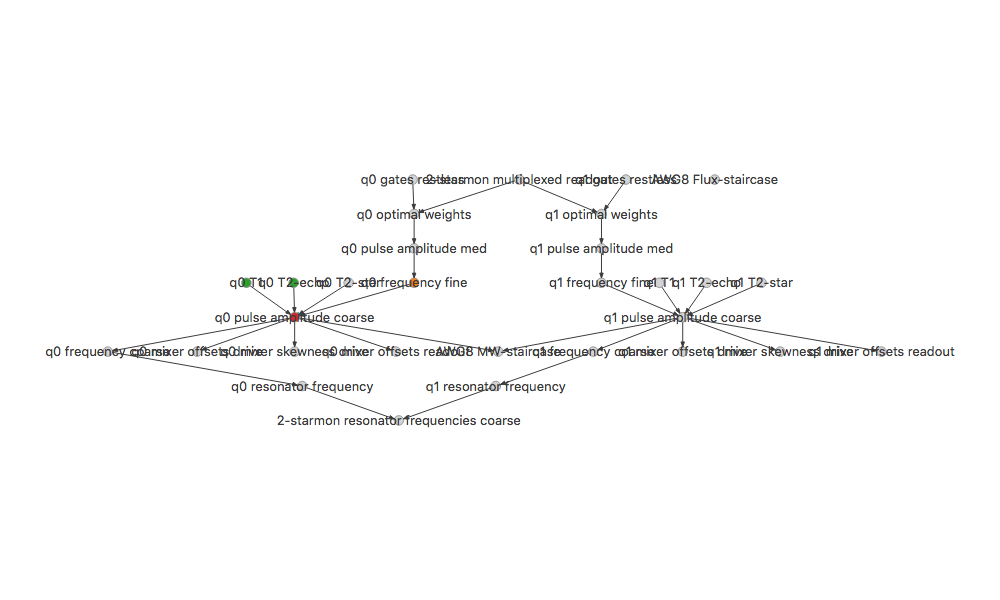

In [130]:
DAG.draw_pg()

In [40]:
import time

In [41]:
import datetime

In [43]:
t0 = datetime.datetime.now() 

In [48]:
(datetime.datetime.now() -t0).total_seconds()

39.13327

In [30]:
attr_dict = {'color': 'red'}
n[1].update(attr_dict)
n

('multiplexed readout',
 {'calibrate_function': 'autodepgraph.node_functions.calibration_functions.NotImplementedCalibration',
  'check_function': 'autodepgraph.node_functions.check_functions.return_fixed_value',
  'color': 'red',
  'last_update': datetime.datetime(2018, 3, 15, 12, 1, 5, 653430),
  'state': 'unknown',
  'timeout': inf,
  'tolerance': 0})

In [13]:
nx.compose_all?